In [1]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib


In [2]:
# Reading the data
dft = Table.read('/home/samanehjavadinia/Co-op/Data/ngvs_matched.fits')


In [3]:
dft.columns

<TableColumns names=('ngvsID','x_sex','y_sex','ra_in','dec_in','elongation','umag','gmag','rmag','imag','zmag','ksmag','uerr','gerr','rerr','ierr','zerr','kserr','iC','iCerr','ebv','flags','field','background_g','ug0','gi0','iz0','ik0','p_star','p_gc','p_galx','main_id','ra_cds','dec_cds','coo_err_maj','coo_err_min','coo_err_angle','nbref','ra_sexa','dec_sexa','coo_qual','coo_bibcode','main_type','other_types','radvel','radvel_err','redshift','redshift_err','sp_type','morph_type','plx','plx_err','pmra','pmdec','pm_err_maj','pm_err_min','pm_err_pa','size_maj','size_min','size_angle','B','V','R_cds','J','H','K','u','g','r_cdsa','i','z','angDist')>

In [4]:
dft = dft[['ngvsID','x_sex','y_sex','ra_in','dec_in','elongation','umag','gmag','rmag','imag','zmag','ksmag','uerr'
           ,'gerr','rerr','ierr','zerr','kserr','iC','iCerr','ebv',  
           'field','background_g','ug0','gi0','iz0','ik0','p_star','p_gc','p_galx',
'main_type','other_types']].to_pandas()


In [5]:
# Apply the transformations to all columns
dft = dft.applymap(lambda x: x.decode('UTF-8').strip().upper() if isinstance(x, bytes) else x)

In [6]:
dft = dft.drop(columns=['ngvsID','field','x_sex','y_sex','ra_in','dec_in', 'other_types'])

In [7]:
dft.head()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,...,ebv,background_g,ug0,gi0,iz0,ik0,p_star,p_gc,p_galx,main_type
0,0.0,35.000000,24.950600,99.0,25.932199,21.135799,99.0,20.00000,0.17775,0.0,...,0.025,0.090464,10.026175,-1.021175,4.784325,99.0,5.657040e-01,3.707125e-23,0.434296,NaN
1,0.0,24.132299,23.497400,99.0,22.803200,22.702600,99.0,0.06600,0.04860,0.0,...,0.026,0.226451,0.610746,0.653042,0.088042,99.0,3.812974e-06,4.419344e-03,0.995577,NaN
2,0.0,24.999500,24.631201,99.0,23.638500,22.843901,99.0,0.15720,0.13110,0.0,...,0.025,0.062369,0.345075,0.953125,0.782525,99.0,3.343125e-08,1.746328e-04,0.999825,NaN
3,0.0,24.627399,23.912701,99.0,23.628300,22.960899,99.0,0.10215,0.06975,0.0,...,0.026,-0.081988,0.690546,0.243242,0.654842,99.0,1.545674e-04,6.319930e-04,0.999213,NaN
4,0.0,20.023199,18.309601,99.0,17.076799,16.884600,99.0,0.00345,0.00150,0.0,...,0.025,3.120640,1.690375,1.193225,0.180125,99.0,8.395232e-14,4.673958e-07,1.000000,NaN


In [8]:
dft.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'main_type'],
      dtype='object')

In [9]:
dft.shape

(4496783, 25)

In [10]:
dft_cleaned = dft.dropna(subset=['main_type'])
unlabeled_data = dft[dft['main_type'].isna()]

In [11]:
dft_cleaned.shape

(23524, 25)

In [12]:
unlabeled_data.shape

(4473259, 25)

In [13]:
unlabeled_data = unlabeled_data.copy()

In [14]:
dft = dft_cleaned.copy()

In [15]:
pd.set_option('display.max_columns', None)
dft.describe()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,ierr,zerr,kserr,iC,iCerr,ebv,background_g,ug0,gi0,iz0,ik0,p_star,p_gc,p_galx
count,23524.0,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.0,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.0,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.0,2.352400e+04,2.352400e+04,23524.000000
mean,0.0,22.962554,21.757558,89.909754,20.738681,20.548688,99.0,0.100905,0.012668,0.005354,0.014126,0.026740,99.0,0.123598,0.032290,0.027327,8.297870,1.179609,0.975618,0.176794,99.0,7.874848e-02,2.663660e-01,0.654886
std,0.0,2.015630,1.692552,24.901835,1.559912,1.570455,0.0,1.003217,0.016688,0.015204,0.022784,0.052515,0.0,0.143800,0.055814,0.006917,25.115125,0.793165,0.724857,0.194947,0.0,2.290172e-01,4.039314e-01,0.431920
min,0.0,18.013000,18.000999,17.428699,16.357300,15.496000,99.0,0.000750,0.000450,0.000000,0.000450,0.000300,99.0,-0.199700,0.000684,0.014000,-1.579870,-0.052553,-1.035709,-2.353292,99.0,0.000000e+00,0.000000e+00,0.000248
25%,0.0,21.552501,20.596651,99.000000,19.762475,19.563400,99.0,0.005850,0.002250,0.000000,0.002700,0.004350,99.0,0.007200,0.005468,0.022000,0.154022,0.738118,0.567158,0.064942,99.0,9.563862e-43,0.000000e+00,0.107442
50%,0.0,23.239250,21.929399,99.000000,20.726399,20.506750,99.0,0.021300,0.006000,0.000000,0.005700,0.009750,99.0,0.058700,0.011502,0.026000,0.559987,1.090164,0.799659,0.159487,99.0,5.388125e-08,1.114193e-12,0.999885
75%,0.0,24.458099,23.055700,99.000000,21.789376,21.606450,99.0,0.063300,0.015900,0.003150,0.013950,0.025800,99.0,0.269000,0.031396,0.031000,3.026540,1.608561,1.380041,0.294936,99.0,1.464591e-03,6.693670e-01,1.000000
max,0.0,35.000000,24.999300,99.000000,25.135799,26.770800,99.0,20.000000,0.154050,0.298800,0.432750,3.031050,99.0,0.400000,1.228558,0.071000,614.604004,14.219675,3.957191,3.609008,99.0,9.997522e-01,9.994484e-01,1.000000


In [16]:
dft['main_type'].value_counts()

GLCL               4568
GLCL?_CANDIDATE    3381
GALAXY             3346
QSO                3264
GINCL              2980
                   ... 
ULX                   1
ERUPTIVE*             1
CLG_CANDIDATE         1
LENSEDG               1
C*                    1
Name: main_type, Length: 76, dtype: int64

In [17]:
# Setting the max rows option to display all rows
pd.set_option('display.max_rows', None)
dft['main_type'].value_counts()

GLCL                 4568
GLCL?_CANDIDATE      3381
GALAXY               3346
QSO                  3264
GINCL                2980
STAR                 2742
WD*_CANDIDATE         445
BCLG                  383
X                     359
RADIO                 271
LSB_G                 209
LOW-MASS*             199
WD*                   162
RRLYR                 142
UNKNOWN_CANDIDATE     127
SEYFERT_1             127
AGN_CANDIDATE         119
XB                    103
CLG                    95
HII                    64
BLUE                   63
HB*                    38
RGB*                   28
PN?_CANDIDATE          26
QSO_CANDIDATE          25
EB*                    22
BROWND*_CANDIDATE      16
PULSV*DELSCT           16
PM*                    14
GINGROUP               13
PN                     12
G_CANDIDATE            11
PEC*                   11
AGN                     9
RADIOG                  9
BLLAC                   9
COMPACT_GR_G            9
BYDRA                   8
SN          

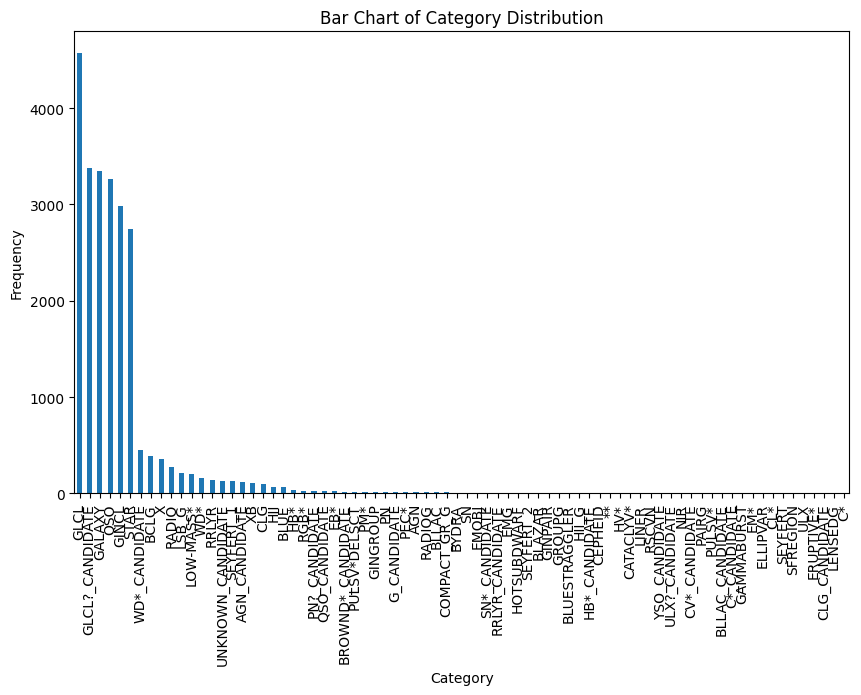

In [18]:
# Create and display the pie chart of the new column
category_counts = dft['main_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

The number of different categories in the new grouped column: 10


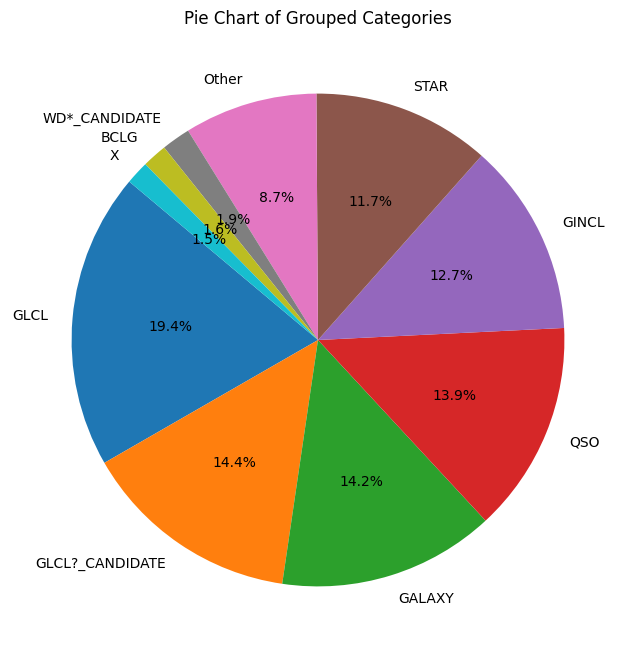

In [19]:
# Count the occurrences of each category
category_counts = dft['main_type'].value_counts()

# Specify the categorical column
category_column = 'main_type'

# Define the threshold for rare categories
threshold = 300  # Categories with counts less than or equal to this will be grouped into "Other"

# Count the occurrences of each category
category_counts = dft[category_column].value_counts()

# Identify the rare categories
rare_categories = category_counts[category_counts <= threshold].index

# Create a new column with grouped categories
dft['grouped_category'] = dft[category_column].apply(lambda x: 'Other' if x in rare_categories else x)

# Print the number of different categories in the new column
num_categories = dft['grouped_category'].nunique()
print(f'The number of different categories in the new grouped column: {num_categories}')



# Count the occurrences of each category
category_counts = dft['grouped_category'].value_counts()


# Create and display the pie chart of the new column
category_counts = dft['grouped_category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Grouped Categories')
plt.show()

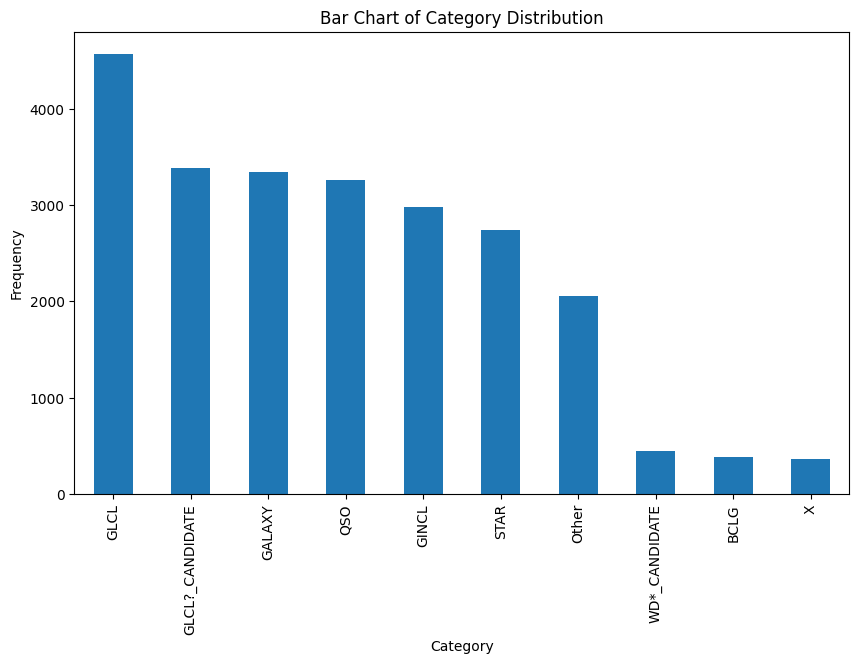

In [20]:
# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [21]:
dft['grouped_category'].value_counts()

GLCL               4568
GLCL?_CANDIDATE    3381
GALAXY             3346
QSO                3264
GINCL              2980
STAR               2742
Other              2056
WD*_CANDIDATE       445
BCLG                383
X                   359
Name: grouped_category, dtype: int64

In [22]:
dft.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'main_type', 'grouped_category'],
      dtype='object')

In [23]:
dft = dft.drop(columns='main_type')

In [24]:
# Get the unique types in the 'grouped_category' column
unique_types = dft['grouped_category'].apply(type).unique()
print("Different types in 'grouped_category' column:", unique_types)

Different types in 'grouped_category' column: [<class 'str'>]


In [25]:
# Ensure all values in 'grouped_category' are strings
dft['grouped_category'] = dft['grouped_category'].astype(str)

In [26]:
df = dft.copy()

In [27]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding
label_encoder = LabelEncoder()
df['main_type_encoded'] = label_encoder.fit_transform(df['grouped_category'])

# Save the encoder to disk
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [28]:
df.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'grouped_category', 'main_type_encoded'],
      dtype='object')

/tmp/ipykernel_1604/3090682606.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


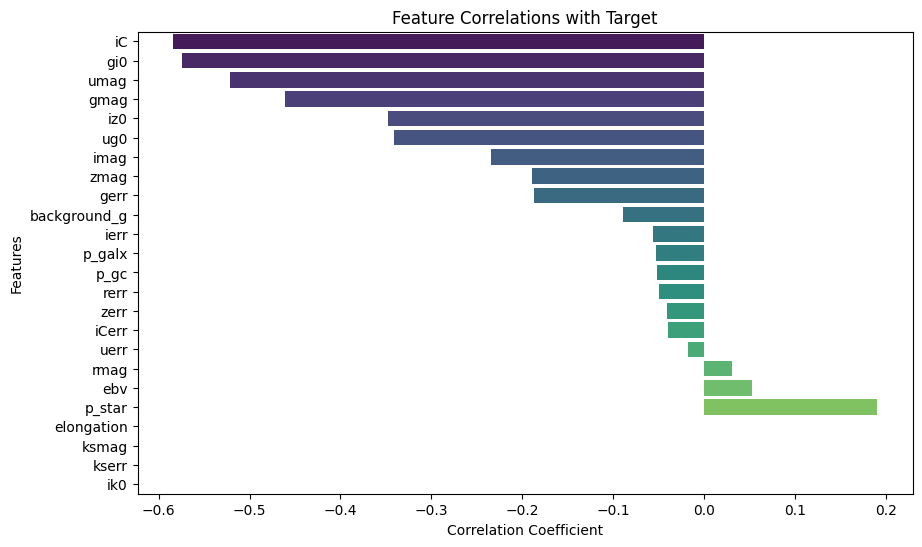

In [29]:
 # Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlations of the features with the target
correlation_with_target = correlation_matrix['main_type_encoded'].drop('main_type_encoded')


# Sort correlations
sorted_correlations = correlation_with_target.sort_values()

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette="viridis")
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

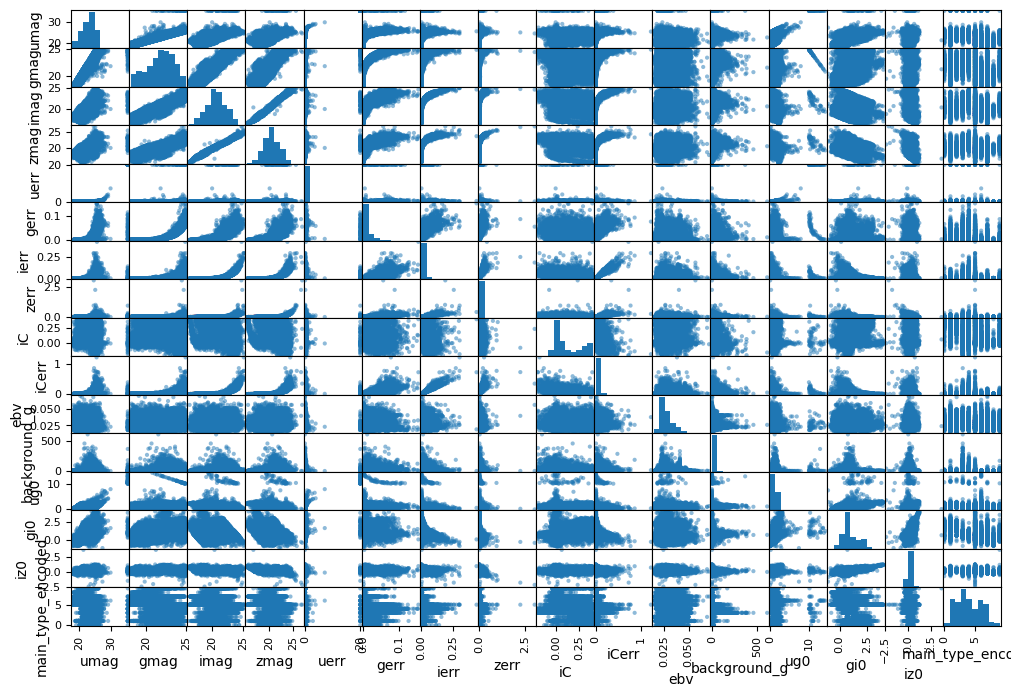

In [30]:
from pandas.plotting import scatter_matrix

attributes = [ 'umag', 'gmag', 'imag', 'zmag',
       'uerr', 'gerr', 'ierr', 'zerr', 'iC', 'iCerr', 'ebv', 'background_g',
       'ug0', 'gi0', 'iz0', 'main_type_encoded']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

In [31]:
# df = df.drop(columns=[ 'elongation','ik0' , 'ksmag', 'kserr', 'rmag', 'rerr', 'p_galx', 'p_star', 'p_gc', 'grouped_category'])
df = df.drop(columns=[ 'p_galx', 'p_star', 'p_gc', 'grouped_category'])

In [32]:
unlabeled_data.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'main_type'],
      dtype='object')

In [33]:
unlabeled_data['main_type'].value_counts()

Series([], Name: main_type, dtype: int64)

In [34]:
unlabeled_data = unlabeled_data.drop(columns=[ 'p_galx', 'p_star', 'p_gc','main_type'])

In [35]:
unlabeled_data.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0'],
      dtype='object')

In [36]:
from tabulate import tabulate

# Print the DataFrame columns in a tabulated format
columns = df.columns.tolist()
print(tabulate([[col] for col in columns], headers=['Columns'], tablefmt='grid'))

+-------------------+
| Columns           |
+===================+
| elongation        |
+-------------------+
| umag              |
+-------------------+
| gmag              |
+-------------------+
| rmag              |
+-------------------+
| imag              |
+-------------------+
| zmag              |
+-------------------+
| ksmag             |
+-------------------+
| uerr              |
+-------------------+
| gerr              |
+-------------------+
| rerr              |
+-------------------+
| ierr              |
+-------------------+
| zerr              |
+-------------------+
| kserr             |
+-------------------+
| iC                |
+-------------------+
| iCerr             |
+-------------------+
| ebv               |
+-------------------+
| background_g      |
+-------------------+
| ug0               |
+-------------------+
| gi0               |
+-------------------+
| iz0               |
+-------------------+
| ik0               |
+-------------------+
| main_typ

In [37]:
# Save the train and test datasets to CSV files
df.to_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv', index=False)
unlabeled_data.to_csv('/home/samanehjavadinia/Co-op/Data/unlabeled_data.csv', index=False)

#############LOading
###########
#######
#########
#########


In [38]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib

In [39]:
# If you want to load the data later, you can use the following code
df = pd.read_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv')
unlabeled_data = pd.read_csv('/home/samanehjavadinia/Co-op/Data/unlabeled_data.csv')
# Load the encoder from disk
label_encoder = joblib.load('label_encoder.pkl')


In [40]:
df.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'main_type_encoded'],
      dtype='object')

In [41]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)
# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']

In [42]:
X_train.head()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,ierr,zerr,kserr,iC,iCerr,ebv,background_g,ug0,gi0,iz0,ik0
12720,0.0,23.099199,21.361099,99.0000,19.529800,19.214701,99.0,0.01965,0.00345,0.00000,0.00210,0.00315,99.0,0.3386,0.003445,0.018,0.610521,1.721378,1.802806,0.306406,99.0
1662,0.0,19.687000,18.801800,99.0000,18.363400,18.289000,99.0,0.00225,0.00090,0.00000,0.00105,0.00180,99.0,0.0104,0.002621,0.027,0.180993,0.860117,0.395659,0.061359,99.0
4351,0.0,20.954300,20.351700,99.0000,19.963200,19.931000,99.0,0.00420,0.00195,0.00000,0.00315,0.00585,99.0,0.0164,0.006954,0.022,0.078900,0.582162,0.353674,0.021574,99.0
13246,0.0,23.454700,22.315100,21.8036,21.532499,21.361500,99.0,0.02265,0.00615,0.00630,0.00870,0.01665,99.0,0.1596,0.019230,0.024,1.598970,1.117304,0.744608,0.159408,99.0
9664,0.0,25.041000,23.950600,99.0000,23.100000,22.928499,99.0,0.11100,0.03255,0.04245,0.04530,0.09480,99.0,0.1133,0.093398,0.022,15.291100,1.069962,0.815774,0.160874,99.0


In [43]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_numeric_columns(train_df, test_df):
    # Identify non-numeric and numeric columns
    non_numeric_columns = train_df.select_dtypes(include=['object']).columns
    numeric_columns = train_df.select_dtypes(exclude=['object']).columns

    # Separate non-numeric and numeric columns
    train_non_numeric = train_df[non_numeric_columns]
    train_numeric = train_df[numeric_columns]

    test_non_numeric = test_df[non_numeric_columns]
    test_numeric = test_df[numeric_columns]

    # Handle missing values in numeric columns
    train_numeric = train_numeric.dropna()
    test_numeric = test_numeric.dropna()
    # Alternatively, fill missing values
    # train_numeric = train_numeric.fillna(train_numeric.mean())
    # test_numeric = test_numeric.fillna(test_numeric.mean())

    # Scale the numeric columns
    scaler = MinMaxScaler()
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled = scaler.transform(test_numeric)

    # Convert the scaled array back to DataFrames
    train_numeric_scaled = pd.DataFrame(train_numeric_scaled, columns=numeric_columns)
    test_numeric_scaled = pd.DataFrame(test_numeric_scaled, columns=numeric_columns)

    # Combine the scaled numeric columns with the non-numeric columns
    train_scaled = pd.concat([train_numeric_scaled, train_non_numeric.reset_index(drop=True)], axis=1)
    test_scaled = pd.concat([test_numeric_scaled, test_non_numeric.reset_index(drop=True)], axis=1)

    return train_scaled, test_scaled

# Example usage
# df = pd.read_csv('your_dataset.csv')  # Load your dataset
X_train_scaled, X_test_scaled = scale_numeric_columns(X_train, X_test)
# print("Scaled train data:", X_train_scaled.head())
# print("Scaled test data:", X_test_scaled.head())


In [44]:
X_train.head()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,ierr,zerr,kserr,iC,iCerr,ebv,background_g,ug0,gi0,iz0,ik0
12720,0.0,23.099199,21.361099,99.0000,19.529800,19.214701,99.0,0.01965,0.00345,0.00000,0.00210,0.00315,99.0,0.3386,0.003445,0.018,0.610521,1.721378,1.802806,0.306406,99.0
1662,0.0,19.687000,18.801800,99.0000,18.363400,18.289000,99.0,0.00225,0.00090,0.00000,0.00105,0.00180,99.0,0.0104,0.002621,0.027,0.180993,0.860117,0.395659,0.061359,99.0
4351,0.0,20.954300,20.351700,99.0000,19.963200,19.931000,99.0,0.00420,0.00195,0.00000,0.00315,0.00585,99.0,0.0164,0.006954,0.022,0.078900,0.582162,0.353674,0.021574,99.0
13246,0.0,23.454700,22.315100,21.8036,21.532499,21.361500,99.0,0.02265,0.00615,0.00630,0.00870,0.01665,99.0,0.1596,0.019230,0.024,1.598970,1.117304,0.744608,0.159408,99.0
9664,0.0,25.041000,23.950600,99.0000,23.100000,22.928499,99.0,0.11100,0.03255,0.04245,0.04530,0.09480,99.0,0.1133,0.093398,0.022,15.291100,1.069962,0.815774,0.160874,99.0


########### Training on XGBoost
############
############
###########
###########

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.22      0.29        77
           1       0.62      0.59      0.61       669
           2       0.71      0.83      0.76       596
           3       0.76      0.84      0.80       914
           4       0.72      0.72      0.72       676
           5       0.54      0.32      0.40       411
           6       0.80      0.89      0.84       653
           7       0.80      0.81      0.80       548
           8       0.54      0.49      0.51        89
           9       0.33      0.12      0.18        72

    accuracy                           0.72      4705
   macro avg       0.62      0.58      0.59      4705
weighted avg       0.70      0.72      0.70      4705

Label Mapping: {'BCLG': 0, 'GALAXY': 1, 'GINCL': 2, 'GLCL': 3, 'GLCL?_CANDIDATE': 4, 'Other': 5, 'QSO': 6, 'STAR': 7, 'WD*_CANDIDATE': 8, 'X': 9}
['BCLG', 'GALAXY', 'GINCL', 'GLCL', 'GLCL?_CANDIDATE', 'O

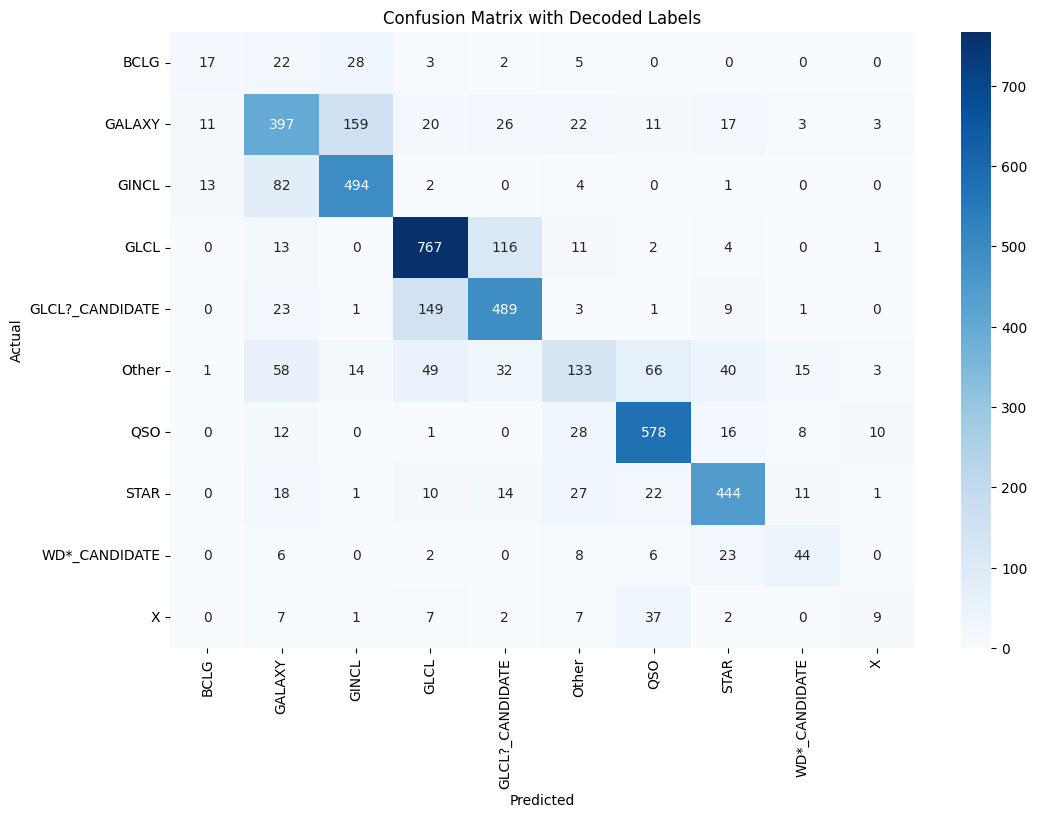

Model saved to xgboost_model.pkl


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import xgboost as xgb
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [46]:
# Get the index of the label 'GLCL'
glcl_index = label_mapping["GLCL"]

# Extract the row and column corresponding to 'GLCL' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'GLCL'
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'GLCL'
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label GLCL: {true_positives_glcl}')
print(f'Number of false predictions for label GLCL: {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label GLCL: {accuracy_glcl:.2f}')



Number of correct predictions for label GLCL: 767
Number of false predictions for label GLCL: 390
Accuracy for label GLCL: 0.92


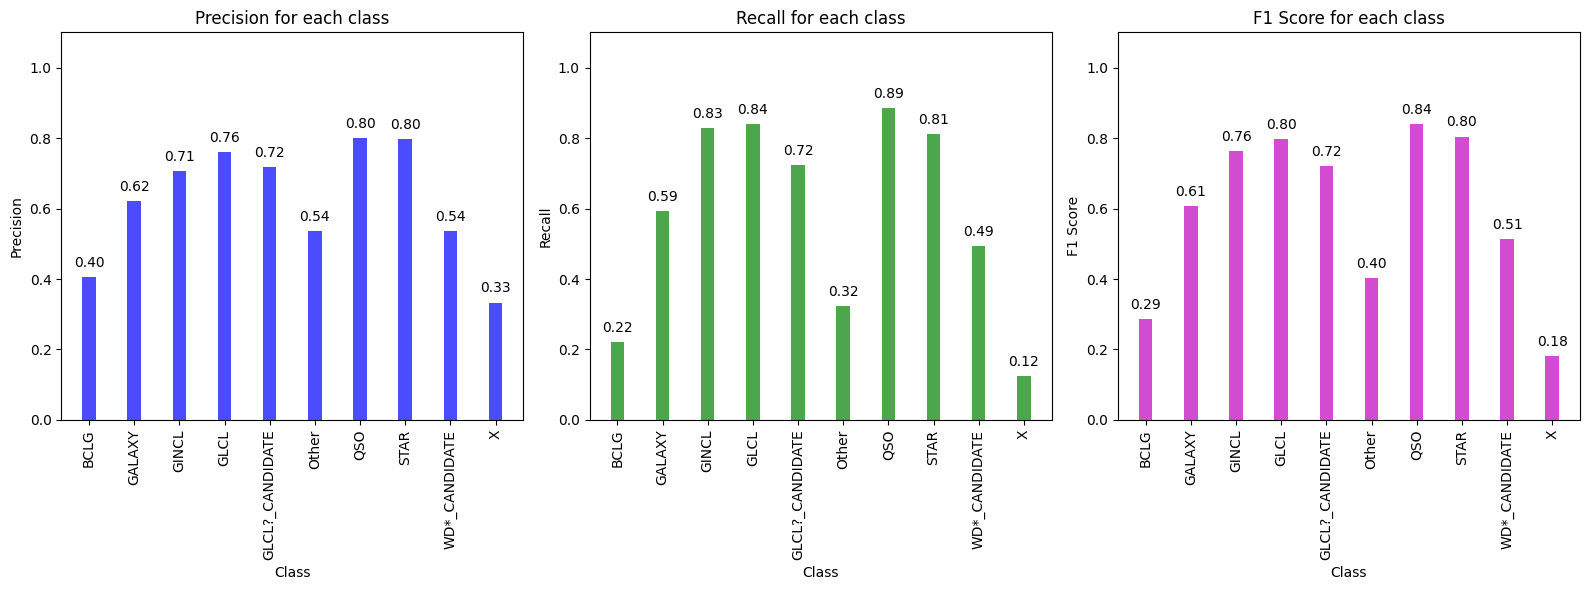

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
num_classes = conf_matrix.shape[0]

# Initialize lists to store precision, recall, and f1 score for each label
precisions = []
recalls = []
f1_scores = []



# Calculate precision, recall, and f1 score for each class
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each class
labels = list(label_mapping.keys())
x = np.arange(len(labels))
bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()


###########Training on xgboost with binary classification#########

In [48]:
y_train.value_counts()

3    3654
4    2705
1    2677
6    2611
2    2384
7    2194
5    1645
8     356
0     306
9     287
Name: main_type_encoded, dtype: int64

In [49]:
y_test.value_counts()

3    914
4    676
1    669
6    653
2    596
7    548
5    411
8     89
0     77
9     72
Name: main_type_encoded, dtype: int64

In [50]:
X_train.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0'],
      dtype='object')

Optimal Threshold: 0.39
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3791
           1       0.76      0.85      0.80       914

    accuracy                           0.92      4705
   macro avg       0.86      0.89      0.88      4705
weighted avg       0.92      0.92      0.92      4705



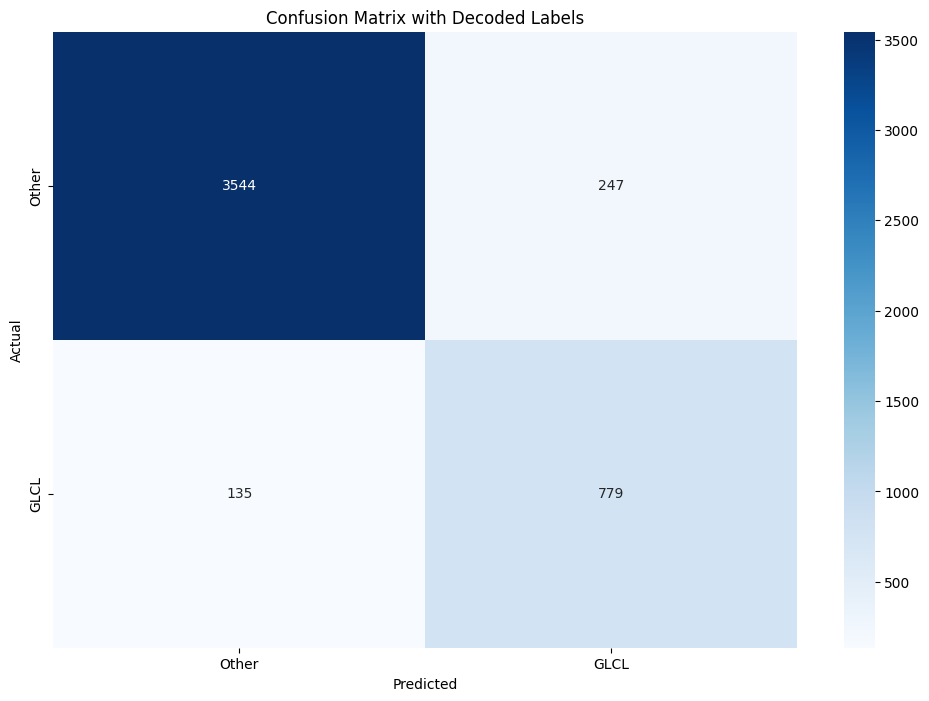

Model saved to xgboost_model_Binary_Classification.pkl


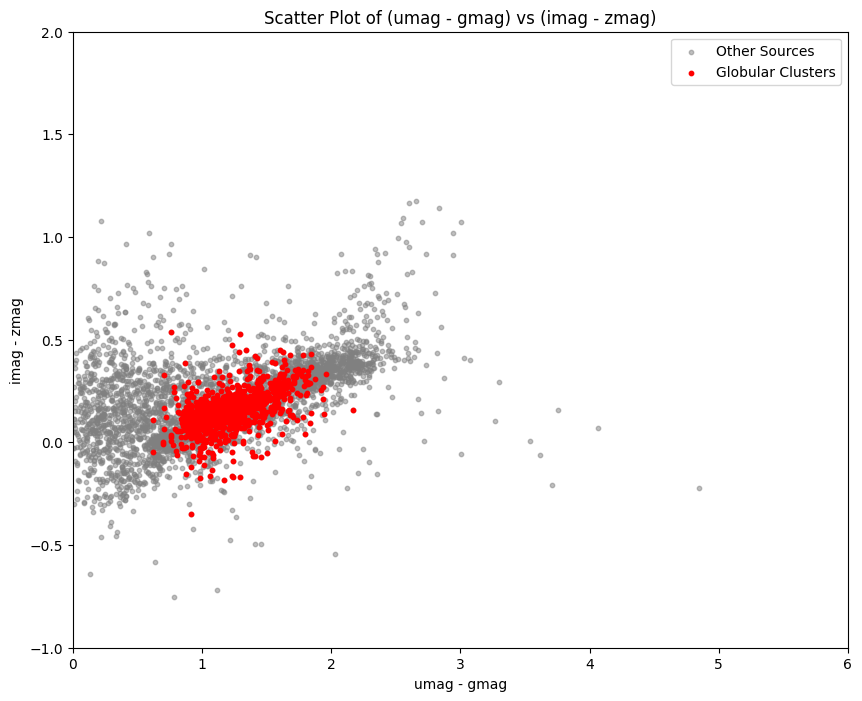

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import xgboost as xgb

# Decode the encoded labels back to the original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test)



# Important class
important_class = "GLCL"

# Converting to binary labels
y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])

# Create a mapping for visualization
binary_to_original_mapping = {
    1: important_class,
    0: 'Other'
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# Train the classifier
xgb_classifier.fit(X_train, y_train_binary)

# Make predictions on the test set

# y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]


# Make predictions on the unlabeled dataset



# Determine the optimal threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f'Optimal Threshold: {optimal_threshold:.2f}')

# Apply the optimal threshold to the predictions
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the classifier
accuracy = accuracy_score(y_test_binary, y_pred)
report = classification_report(y_test_binary, y_pred)
conf_matrix = confusion_matrix(y_test_binary, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Decode the labels using the dictionary
decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]


# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model_Binary_Classification.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')


# Scatter plot of (umag - gmag) vs (imag - zmag) with globular clusters highlighted
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    X_test['umag'] - X_test['gmag'],  # Difference between umag and gmag for x-axis
    X_test['imag'] - X_test['zmag'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight globular clusters
plt.scatter(
    X_test['umag'][y_pred == 1] - X_test['gmag'][y_pred == 1],  # x-axis values for predicted globular clusters
    X_test['imag'][y_pred == 1] - X_test['zmag'][y_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()





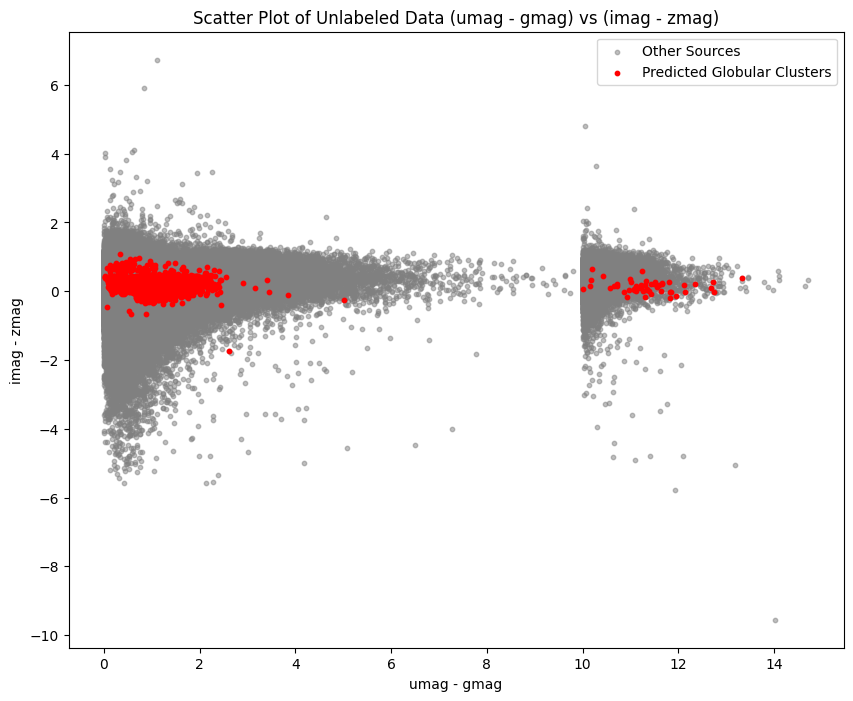

In [54]:
# Make predictions on the unlabeled dataset
unlabeled_data_proba = xgb_classifier.predict_proba(unlabeled_data)[:, 1]
unlabeled_data_pred = (unlabeled_data_proba >= optimal_threshold).astype(int)


# Scatter plot for the unlabeled data
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    unlabeled_data['umag'] - unlabeled_data['gmag'],  # Difference between umag and gmag for x-axis
    unlabeled_data['imag'] - unlabeled_data['zmag'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight predicted globular clusters
plt.scatter(
    unlabeled_data['umag'][unlabeled_data_pred == 1] - unlabeled_data['gmag'][unlabeled_data_pred == 1],  # x-axis values for predicted globular clusters
    unlabeled_data['imag'][unlabeled_data_pred == 1] - unlabeled_data['zmag'][unlabeled_data_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Predicted Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
# plt.xlim(0, 6)  # Limit the range for x-axis
# plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Unlabeled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store precision, recall, accuracy, and F1 score for each label
precisions = []
recalls = []
f1_scores = []

print(binary_to_original_mapping.items())

# Calculate precision, recall, accuracy, and F1 score for each label
for index, label in binary_to_original_mapping.items():  # Swap label and index
    print(f"Processing index: {index}, label: {label}")
    
    if index == 1:
        print("Index is 1")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[1, 1]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[0, 1]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[1, 0]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[0, 0]
    elif index == 0:
        print("Index is 0")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[0, 0]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[1, 0]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[0, 1]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[1, 1]
    else:
        assert False, f"Unexpected label value: {index}"  # Assert for unexpected values
        print("Index is neither 0 nor 1, skipping this index")
        continue  # Skip labels not covered in the binary mapping

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each label
labels = list(binary_to_original_mapping.values())
x = np.arange(len(labels))

bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

########### Training on Random Forest
############
############
###########
###########

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()


# Feature importance
feature_importances = rf_classifier.feature_importances_
features = X_train.columns

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances in Random Forest Classifier')
plt.show()

# Save the trained model to a file
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [ ]:
#  Get the index of the label 'GLCL'
glcl_index = label_mapping["GLCL"]

# Extract the row and column corresponding to 'GLCL' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'GLCL'
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'GLCL'
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label GLCL: {true_positives_glcl}')
print(f'Number of false predictions for label GLCL: {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label GLCL: {accuracy_glcl:.2f}')



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
num_classes = conf_matrix.shape[0]

# Initialize lists to store precision, recall, and f1 score for each label
precisions = []
recalls = []
f1_scores = []



# Calculate precision, recall, and f1 score for each class
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each class
labels = list(label_mapping.keys())
x = np.arange(len(labels))
bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

######## Training on random Forest by Binarization #######

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Decode the encoded labels back to the original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Important class
important_class = "GLCL"

# Converting to binary labels
y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])

# Create a mapping for visualization
binary_to_original_mapping = {
    1: important_class,
    0: 'Other'
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train_binary)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test_binary, y_pred)
report = classification_report(y_test_binary, y_pred)
conf_matrix = confusion_matrix(y_test_binary, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Decode the labels using the dictionary
decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'RandomForest_model_Binary_Classification.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store precision, recall, accuracy, and F1 score for each label
precisions = []
recalls = []
f1_scores = []

print(binary_to_original_mapping.items())

# Calculate precision, recall, accuracy, and F1 score for each label
for index, label in binary_to_original_mapping.items():  # Swap label and index
    print(f"Processing index: {index}, label: {label}")
    
    if index == 1:
        print("Index is 1")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[1, 1]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[0, 1]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[1, 0]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[0, 0]
    elif index == 0:
        print("Index is 0")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[0, 0]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[1, 0]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[0, 1]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[1, 1]
    else:
        assert False, f"Unexpected label value: {index}"  # Assert for unexpected values
        print("Index is neither 0 nor 1, skipping this index")
        continue  # Skip labels not covered in the binary mapping

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each label
labels = list(binary_to_original_mapping.values())
x = np.arange(len(labels))

bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()